# VGG16

In [1]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
    ])

trainset = datasets.CIFAR10(root='~/.pytorch/CIFAR10',train=True, download=True,transform=transform)
testset = datasets.CIFAR10(root='~/.pytorch/CIFAR10',train=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified


In [5]:
for images, labels in trainloader:
  print(images.size(), labels.size())
  break

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [6]:
model = models.vgg16(pretrained = True)
model 

c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [12]:
for param in model.parameters():
    param.requires_grad = False

Recall the structure of VGG16, this architecture receives 4096 images in the classifier layers, and our dataset has 10 classes, so we will output 10 features

![image info](./resources/im1.png)

In [14]:

model.classifier[-1] = nn.Sequential(
                       nn.Linear(in_features=4096, out_features = 10),
                       nn.LogSoftmax(dim = 1)
                       )

In [15]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

Negative Log Likelihood Loss (NLLLoss), pytorch's softmax does not work directly with NLLLoss, <br>we ought to choose a better criterion like CrossEntropyLoss which combines <i>nn.LogSoftmax</i> and <i>nn.NNLLoss</i>

In [16]:
criterion = nn.NLLLoss()

For using autograd, we first need to set <i>.requires_grad = True</i> (already done) <br>
and then call <i>.backward()</i>

## Training the Fixed Feature Extractor

In [17]:
from torch.optim import Adam

model = model.to(device)
optimizer = Adam(model.parameters())

In [18]:
n_epochs = 1
batch_loss = 0

for e in range(n_epochs):
    cum_epoch_loss = 0

    for batch, (images, labels) in enumerate(trainloader,1):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        logps = model(images)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        
        batch_loss += loss.item()
        print(f'Epoch({e}/{n_epochs} : Batch number({batch}/{len(trainloader)})  Batch loss : {loss.item()}')
        
    print(f'Training loss : {batch_loss/len(trainloader)}')  

Epoch(0/1 : Batch number(1/782)  Batch loss : 2.4563777446746826
Epoch(0/1 : Batch number(2/782)  Batch loss : 2.2360973358154297
Epoch(0/1 : Batch number(3/782)  Batch loss : 2.053443193435669
Epoch(0/1 : Batch number(4/782)  Batch loss : 1.9148361682891846
Epoch(0/1 : Batch number(5/782)  Batch loss : 1.949463963508606
Epoch(0/1 : Batch number(6/782)  Batch loss : 1.653280258178711
Epoch(0/1 : Batch number(7/782)  Batch loss : 1.5256456136703491
Epoch(0/1 : Batch number(8/782)  Batch loss : 1.4019880294799805
Epoch(0/1 : Batch number(9/782)  Batch loss : 1.3135673999786377
Epoch(0/1 : Batch number(10/782)  Batch loss : 1.205098271369934
Epoch(0/1 : Batch number(11/782)  Batch loss : 1.0892411470413208
Epoch(0/1 : Batch number(12/782)  Batch loss : 1.2633581161499023
Epoch(0/1 : Batch number(13/782)  Batch loss : 1.117632508277893
Epoch(0/1 : Batch number(14/782)  Batch loss : 1.1367324590682983
Epoch(0/1 : Batch number(15/782)  Batch loss : 1.124311089515686
Epoch(0/1 : Batch number(

## Evaluation and visualization

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [20]:
CIFAR10_classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


model.to('cpu')

model.eval()

with torch.no_grad():
  images, labels = next(iter(testloader))
  logps = model(images)
  
  output = torch.exp(logps)
  print(output)


tensor([[1.2297e-03, 7.0803e-03, 2.0056e-03, 8.9976e-01, 2.6151e-04, 3.5097e-02,
         4.9403e-02, 2.6150e-03, 2.3219e-03, 2.2510e-04],
        [5.0316e-03, 2.0313e-01, 2.1764e-05, 3.8828e-05, 2.9957e-06, 2.4094e-06,
         3.3362e-06, 1.1613e-06, 7.9050e-01, 1.2655e-03],
        [2.4867e-04, 1.0400e-03, 3.2958e-07, 2.2296e-07, 1.1985e-07, 6.7199e-09,
         9.4483e-09, 1.5534e-07, 9.9869e-01, 1.8817e-05],
        [3.7577e-01, 2.4743e-03, 4.9947e-02, 9.3132e-02, 1.2629e-03, 1.3070e-03,
         1.6448e-03, 1.2585e-03, 4.7214e-01, 1.0610e-03],
        [1.2847e-07, 1.1941e-07, 1.6920e-03, 1.6438e-04, 6.7938e-05, 1.1645e-05,
         9.9806e-01, 8.8064e-08, 7.6333e-08, 4.7699e-08],
        [8.2505e-06, 2.4815e-06, 9.5060e-05, 1.0077e-01, 2.5422e-02, 2.5614e-01,
         6.1710e-01, 4.4319e-04, 6.9191e-07, 2.5732e-05],
        [2.6546e-05, 9.9415e-01, 7.4620e-07, 1.8791e-05, 5.7141e-08, 4.4930e-05,
         4.2348e-06, 1.3014e-05, 1.4093e-05, 5.7280e-03],
        [4.7272e-02, 1.1429

In [21]:
CIFAR10_classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


model.to('cpu')

model.eval()

with torch.no_grad():
  images, labels = next(iter(testloader))
  logps = model(images)
  
  output = torch.exp(logps)
  
  pred = torch.argmax(output,1)
    
model.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

ship


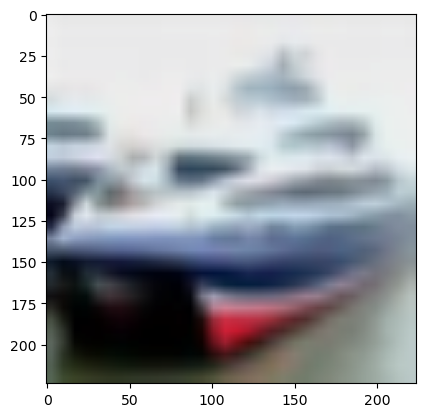

In [23]:
test_image_id=1

def denormalize(tensor):
  tensor = tensor*std+ mean
  return tensor

def show_img(img):
  img = img.numpy().transpose((1,2,0))
  img = denormalize(img)
  img = np.clip(img,0,1)
  plt.imshow(img)
  
def get_CIFAR10_class(id):
  CIFAR10_classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
  return CIFAR10_classes[id]

show_img(images[test_image_id])
print(get_CIFAR10_class(pred[test_image_id]))